In [131]:
!pip install pyspark

In [132]:
# Importing the libraries
from pyspark.sql import SparkSession
from pyspark.sql.functions import countDistinct, avg,\
count, date_format , max, to_date, col,year, month, day, coalesce, cast
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql.functions import to_date, col
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml import Pipeline

In [133]:
#create a SparkSession
spark=SparkSession.builder.appName('project').config("spark.sql.legacy.timeParserPolicy", "LEGACY").getOrCreate()

In [134]:
# Importing the dataset
df=spark.read.csv('crime.csv', inferSchema=True, header=True)

In [135]:
df.printSchema()

root
 |-- incident_id: long (nullable = true)
 |-- offense_id: long (nullable = true)
 |-- offense_code: integer (nullable = true)
 |-- offense_code_extension: integer (nullable = true)
 |-- offense_type_id: string (nullable = true)
 |-- offense_category_id: string (nullable = true)
 |-- first_occurrence_date: string (nullable = true)
 |-- last_occurrence_date: string (nullable = true)
 |-- reported_date: string (nullable = true)
 |-- incident_address: string (nullable = true)
 |-- geo_x: double (nullable = true)
 |-- geo_y: double (nullable = true)
 |-- geo_lon: double (nullable = true)
 |-- geo_lat: double (nullable = true)
 |-- district_id: string (nullable = true)
 |-- precinct_id: integer (nullable = true)
 |-- neighborhood_id: string (nullable = true)
 |-- is_crime: integer (nullable = true)
 |-- is_traffic: integer (nullable = true)
 |-- victim_count: integer (nullable = true)



In [136]:
 df.columns

['incident_id',
 'offense_id',
 'offense_code',
 'offense_code_extension',
 'offense_type_id',
 'offense_category_id',
 'first_occurrence_date',
 'last_occurrence_date',
 'reported_date',
 'incident_address',
 'geo_x',
 'geo_y',
 'geo_lon',
 'geo_lat',
 'district_id',
 'precinct_id',
 'neighborhood_id',
 'is_crime',
 'is_traffic',
 'victim_count']

In [137]:
# Handling missing values
df = df.dropna()

In [138]:
df.describe().show(5)

+-------+--------------------+--------------------+-----------------+----------------------+--------------------+-------------------+---------------------+--------------------+--------------------+------------------+-----------------+------------------+-------------------+--------------------+------------------+------------------+---------------+--------+----------+------------+
|summary|         incident_id|          offense_id|     offense_code|offense_code_extension|     offense_type_id|offense_category_id|first_occurrence_date|last_occurrence_date|       reported_date|  incident_address|            geo_x|             geo_y|            geo_lon|             geo_lat|       district_id|       precinct_id|neighborhood_id|is_crime|is_traffic|victim_count|
+-------+--------------------+--------------------+-----------------+----------------------+--------------------+-------------------+---------------------+--------------------+--------------------+------------------+-----------------+--

In [139]:
 df.withColumnRenamed('incident_address', 'incident_loc').show(1)

+-----------+----------------+------------+----------------------+--------------------+-------------------+---------------------+--------------------+-------------------+-----------------+---------+---------+----------+----------+-----------+-----------+---------------+--------+----------+------------+
|incident_id|      offense_id|offense_code|offense_code_extension|     offense_type_id|offense_category_id|first_occurrence_date|last_occurrence_date|      reported_date|     incident_loc|    geo_x|    geo_y|   geo_lon|   geo_lat|district_id|precinct_id|neighborhood_id|is_crime|is_traffic|victim_count|
+-----------+----------------+------------+----------------------+--------------------+-------------------+---------------------+--------------------+-------------------+-----------------+---------+---------+----------+----------+-----------+-----------+---------------+--------+----------+------------+
| 2018612468|2018612468299900|        2999|                     0|criminal-mischief...| 

In [140]:
#  Most recent offense categories
most_recent_offenses = df.orderBy(col('reported_date').desc()).select('offense_category_id').limit(8).toPandas()
print("Most Recent Offense Categories:")
print(most_recent_offenses)

Most Recent Offense Categories:
  offense_category_id
0     public-disorder
1     public-disorder
2     public-disorder
3     public-disorder
4    all-other-crimes
5    all-other-crimes
6     public-disorder
7     public-disorder


In [141]:
df.createOrReplaceTempView('crime_data')

In [142]:
#extracts and displays the first 5 records from the crime_data table that are categorized as "public-disorder"
query1 = "SELECT * FROM crime_data WHERE offense_category_id = 'public-disorder'"
result1 = spark.sql(query1).show(5)

+-----------+-----------------+------------+----------------------+--------------------+-------------------+---------------------+--------------------+--------------------+------------------+---------+---------+------------+----------+-----------+-----------+---------------+--------+----------+------------+
|incident_id|       offense_id|offense_code|offense_code_extension|     offense_type_id|offense_category_id|first_occurrence_date|last_occurrence_date|       reported_date|  incident_address|    geo_x|    geo_y|     geo_lon|   geo_lat|district_id|precinct_id|neighborhood_id|is_crime|is_traffic|victim_count|
+-----------+-----------------+------------+----------------------+--------------------+-------------------+---------------------+--------------------+--------------------+------------------+---------+---------+------------+----------+-----------+-----------+---------------+--------+----------+------------+
| 2018612468| 2018612468299900|        2999|                     0|crimin

In [143]:
#Classification of crime records based on their offense_type_id and displays the count of records for each category.
query2 = "SELECT offense_type_id, COUNT(*) AS count FROM crime_data GROUP BY offense_type_id"
result2 = spark.sql(query2).show(5)

+--------------------+-----+
|     offense_type_id|count|
+--------------------+-----+
|drug-opium-or-der...|    7|
|drug-cocaine-possess|   12|
|criminal-mischief...| 6183|
|drug-hallucinogen...|    2|
|criminal-mischief...| 1833|
+--------------------+-----+
only showing top 5 rows



In [144]:
#retrieves and displays the most recent offense_category_id values from the crime_data table, ensuring the latest offense categories appear first in the output.
query3 = "SELECT offense_category_id FROM crime_data ORDER BY reported_date DESC"
result3 = spark.sql(query3).show(8)

+-------------------+
|offense_category_id|
+-------------------+
|    public-disorder|
|    public-disorder|
|    public-disorder|
|    public-disorder|
|   all-other-crimes|
|   all-other-crimes|
|    public-disorder|
|    public-disorder|
+-------------------+
only showing top 8 rows



In [145]:
# Find the maximum and minimum values of the 'victim_count' column
max_victim_count = df.selectExpr('max(victim_count)').collect()[0][0]
min_victim_count = df.selectExpr('min(victim_count)').collect()[0][0]
max_victim_count, min_victim_count

(1, 1)

In [146]:
# Filter the data where 'victim_count' is greater than 1 and 'is_crime' is 1
filtered_data= df.filter((df['victim_count'] > 1) & (df['is_crime'] == 1))
filtered_data.show(5)

+-----------+----------+------------+----------------------+---------------+-------------------+---------------------+--------------------+-------------+----------------+-----+-----+-------+-------+-----------+-----------+---------------+--------+----------+------------+
|incident_id|offense_id|offense_code|offense_code_extension|offense_type_id|offense_category_id|first_occurrence_date|last_occurrence_date|reported_date|incident_address|geo_x|geo_y|geo_lon|geo_lat|district_id|precinct_id|neighborhood_id|is_crime|is_traffic|victim_count|
+-----------+----------+------------+----------------------+---------------+-------------------+---------------------+--------------------+-------------+----------------+-----+-----+-------+-------+-----------+-----------+---------------+--------+----------+------------+
+-----------+----------+------------+----------------------+---------------+-------------------+---------------------+--------------------+-------------+----------------+-----+-----+--

In [147]:
# Filter the data where 'victim_count' is greater than 1 or 'is_crime' is 1
filtered_data_or = df.filter((df['victim_count'] > 1) | (df['is_crime'] == 1))

filtered_data_or.show(5)

+-----------+-----------------+------------+----------------------+--------------------+-------------------+---------------------+--------------------+--------------------+------------------+---------+---------+------------+----------+-----------+-----------+---------------+--------+----------+------------+
|incident_id|       offense_id|offense_code|offense_code_extension|     offense_type_id|offense_category_id|first_occurrence_date|last_occurrence_date|       reported_date|  incident_address|    geo_x|    geo_y|     geo_lon|   geo_lat|district_id|precinct_id|neighborhood_id|is_crime|is_traffic|victim_count|
+-----------+-----------------+------------+----------------------+--------------------+-------------------+---------------------+--------------------+--------------------+------------------+---------+---------+------------+----------+-----------+-----------+---------------+--------+----------+------------+
| 2018612468| 2018612468299900|        2999|                     0|crimin

In [148]:
#Aggregation of data by 'incident_address'
df.groupBy('incident_address').count().show()

+--------------------+-----+
|    incident_address|count|
+--------------------+-----+
|     1319 N MEADE ST|    1|
|      2525 W 6TH AVE|    5|
| 1506 S FEDERAL BLVD|    2|
|    1225 N MONACO ST|    1|
|      1440 N KNOX CT|    1|
|    781 N VALLEJO ST|    2|
|   8720 E COLFAX AVE|    2|
|    2950 W EVANS AVE|    4|
|    10900 E SMITH RD|    2|
|  2207 S CHEROKEE ST|    1|
|   2822 N JACKSON ST|    3|
| 2042 S JOSEPHINE ST|    1|
|         621 17TH ST|    4|
|     3801 E MLK BLVD|    1|
|    777 E SPEER BLVD|    2|
|    4590 N PEORIA ST|    4|
|      4140 N COOK ST|    1|
|    1364 N LEYDEN ST|    1|
|1995 S SHERIDAN BLVD|    1|
|     1329 N GRANT ST|    1|
+--------------------+-----+
only showing top 20 rows



In [149]:
#Aggregation of data by 'victim_count'
df.groupBy('victim_count').count().show()

+------------+-----+
|victim_count|count|
+------------+-----+
|           1|24672|
+------------+-----+



In [150]:
#Aggregation of data by type of crime
df.groupBy('is_crime').count().show()

+--------+-----+
|is_crime|count|
+--------+-----+
|       1|24672|
+--------+-----+



In [151]:
#Aggregation of data by 'reported_date'
df.groupBy('reported_date').count().show()

+--------------------+-----+
|       reported_date|count|
+--------------------+-----+
|5/29/2020 2:15:00 PM|    1|
|1/25/2022 12:16:0...|    1|
|10/11/2022 11:51:...|    1|
| 9/6/2019 8:37:00 AM|    1|
|4/26/2022 9:24:00 AM|    1|
|6/2/2022 10:58:00 AM|    1|
|2/14/2022 9:28:00 AM|    1|
|6/15/2020 2:07:00 PM|    1|
|10/14/2020 6:39:0...|    1|
|6/7/2022 12:34:00 PM|    1|
|11/4/2018 12:10:0...|    1|
|10/21/2020 11:43:...|    1|
|3/29/2020 8:29:00 AM|    1|
|6/1/2020 10:42:00 AM|    1|
|4/23/2021 11:59:0...|    1|
| 4/9/2021 2:54:00 PM|    1|
|5/29/2022 6:26:00 PM|    1|
|4/11/2022 10:35:0...|    1|
|8/16/2021 12:50:0...|    1|
|6/21/2020 11:02:0...|    1|
+--------------------+-----+
only showing top 20 rows



In [152]:
#Average number of victims per type of crime
df.groupBy('offense_type_id').avg('victim_count').show()

+--------------------+-----------------+
|     offense_type_id|avg(victim_count)|
+--------------------+-----------------+
|drug-opium-or-der...|              1.0|
|drug-cocaine-possess|              1.0|
|criminal-mischief...|              1.0|
|drug-hallucinogen...|              1.0|
|criminal-mischief...|              1.0|
|drug-poss-paraphe...|              1.0|
| drug-heroin-possess|              1.0|
|   drug-cocaine-sell|              1.0|
|drug-hallucinogen...|              1.0|
|drug-synth-narcot...|              1.0|
|    drug-heroin-sell|              1.0|
|drug-opium-or-der...|              1.0|
|criminal-mischief...|              1.0|
|drug-methamphetam...|              1.0|
|police-resisting-...|              1.0|
|weapon-by-prev-of...|              1.0|
|drug-methampetami...|              1.0|
|weapon-carrying-p...|              1.0|
| police-interference|              1.0|
|violation-of-cour...|              1.0|
+--------------------+-----------------+
only showing top

In [153]:
#Aggregation of data by type of crime and ranking of results by number of victims per crime
df.groupBy("offense_type_id").sum("victim_count").orderBy("sum(victim_count)").show()

+--------------------+-----------------+
|     offense_type_id|sum(victim_count)|
+--------------------+-----------------+
|prostitution-pimping|                1|
|              bigamy|                1|
|drug-hallucinogen...|                2|
|drug-synth-narcot...|                2|
|drug-methamphetam...|                2|
|drug-marijuana-cu...|                2|
|drug-make-sell-ot...|                2|
|drug-hallucinogen...|                3|
|drug-opium-or-der...|                3|
|         liquor-sell|                3|
|sex-off-registrat...|                3|
|explosive-incendi...|                3|
|obscene-material-mfr|                3|
|    drug-heroin-sell|                5|
|prostitution-enga...|                5|
|violation-of-cust...|                5|
|explosive-incendi...|                5|
|             bribery|                5|
|drug-opium-or-der...|                7|
|              escape|                7|
+--------------------+-----------------+
only showing top

In [154]:
#Identify crimes that occurred in the CBD neighborhood
val1=df.filter(df["neighborhood_id"].like("cbd"))

In [155]:
val1.count()

792

In [156]:
#Identify the most common types of crime in each neighborhood
df.groupBy("neighborhood_id", "offense_type_id").agg(count("offense_type_id").alias("crime_count"))\
.orderBy("crime_count", descending=True).show()

+---------------+--------------------+-----------+
|neighborhood_id|     offense_type_id|crime_count|
+---------------+--------------------+-----------+
|      sunnyside|drug-cocaine-possess|          1|
|  union-station|    drug-heroin-sell|          1|
|        skyland|drug-cocaine-possess|          1|
|  cheesman-park|drug-poss-paraphe...|          1|
|   capitol-hill|drug-poss-paraphe...|          1|
|            dia|    drug-heroin-sell|          1|
|    five-points|drug-opium-or-der...|          1|
|            cbd|drug-synth-narcot...|          1|
|     villa-park|drug-opium-or-der...|          1|
|      ruby-hill|drug-hallucinogen...|          1|
|    bear-valley|drug-hallucinogen...|          1|
|        auraria|drug-poss-paraphe...|          1|
|       westwood|   drug-cocaine-sell|          1|
|      sunnyside| drug-heroin-possess|          1|
|          speer|    drug-heroin-sell|          1|
|    athmar-park| drug-heroin-possess|          1|
|    harvey-park|drug-poss-para

In [157]:
data = spark.read.csv("crime.csv", header=True, inferSchema=True)


In [158]:

data.printSchema()
data.show(5)

root
 |-- incident_id: long (nullable = true)
 |-- offense_id: long (nullable = true)
 |-- offense_code: integer (nullable = true)
 |-- offense_code_extension: integer (nullable = true)
 |-- offense_type_id: string (nullable = true)
 |-- offense_category_id: string (nullable = true)
 |-- first_occurrence_date: string (nullable = true)
 |-- last_occurrence_date: string (nullable = true)
 |-- reported_date: string (nullable = true)
 |-- incident_address: string (nullable = true)
 |-- geo_x: double (nullable = true)
 |-- geo_y: double (nullable = true)
 |-- geo_lon: double (nullable = true)
 |-- geo_lat: double (nullable = true)
 |-- district_id: string (nullable = true)
 |-- precinct_id: integer (nullable = true)
 |-- neighborhood_id: string (nullable = true)
 |-- is_crime: integer (nullable = true)
 |-- is_traffic: integer (nullable = true)
 |-- victim_count: integer (nullable = true)

+-----------+----------------+------------+----------------------+--------------------+---------------

In [159]:
# handle missing values
data=data.dropna()
from pyspark.sql.functions import year, month, dayofweek, hour, to_timestamp
# convert datatype
data_cleaned = data.withColumn("first_occurrence_date", to_timestamp(col("first_occurrence_date"), "M/d/yyyy h:mm:ss a")) \
                   .withColumn("Year", year(col("first_occurrence_date"))) \
                   .withColumn("Month", month(col("first_occurrence_date"))) \
                   .withColumn("DayOfWeek", dayofweek(col("first_occurrence_date"))) \
                   .withColumn("Hour", hour(col("first_occurrence_date")))

data_cleaned.show(5)


+-----------+-----------------+------------+----------------------+--------------------+-------------------+---------------------+--------------------+--------------------+------------------+---------+---------+------------+----------+-----------+-----------+---------------+--------+----------+------------+----+-----+---------+----+
|incident_id|       offense_id|offense_code|offense_code_extension|     offense_type_id|offense_category_id|first_occurrence_date|last_occurrence_date|       reported_date|  incident_address|    geo_x|    geo_y|     geo_lon|   geo_lat|district_id|precinct_id|neighborhood_id|is_crime|is_traffic|victim_count|Year|Month|DayOfWeek|Hour|
+-----------+-----------------+------------+----------------------+--------------------+-------------------+---------------------+--------------------+--------------------+------------------+---------+---------+------------+----------+-----------+-----------+---------------+--------+----------+------------+----+-----+---------+-

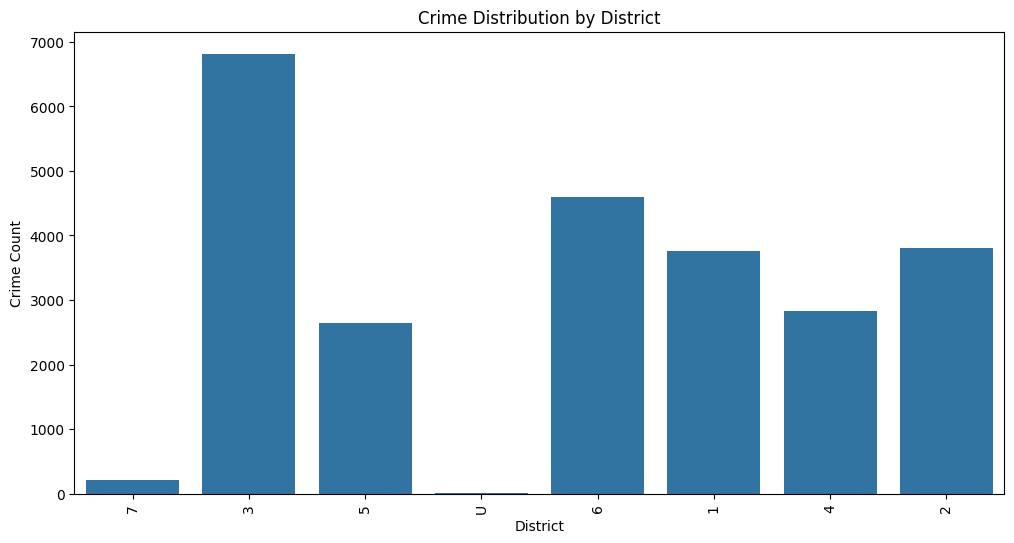

In [160]:
# 1. توزيع الجرائم حسب المقاطعة:
# تحويل البيانات إلى Pandas DataFrame
df_pandas = data_cleaned.groupBy("district_id").count().toPandas()

# رسم البيانات
plt.figure(figsize=(12, 6))
sns.barplot(x="district_id", y="count", data=df_pandas)
plt.title("Crime Distribution by District")
plt.xlabel("District")
plt.ylabel("Crime Count")
plt.xticks(rotation=90)
plt.show()

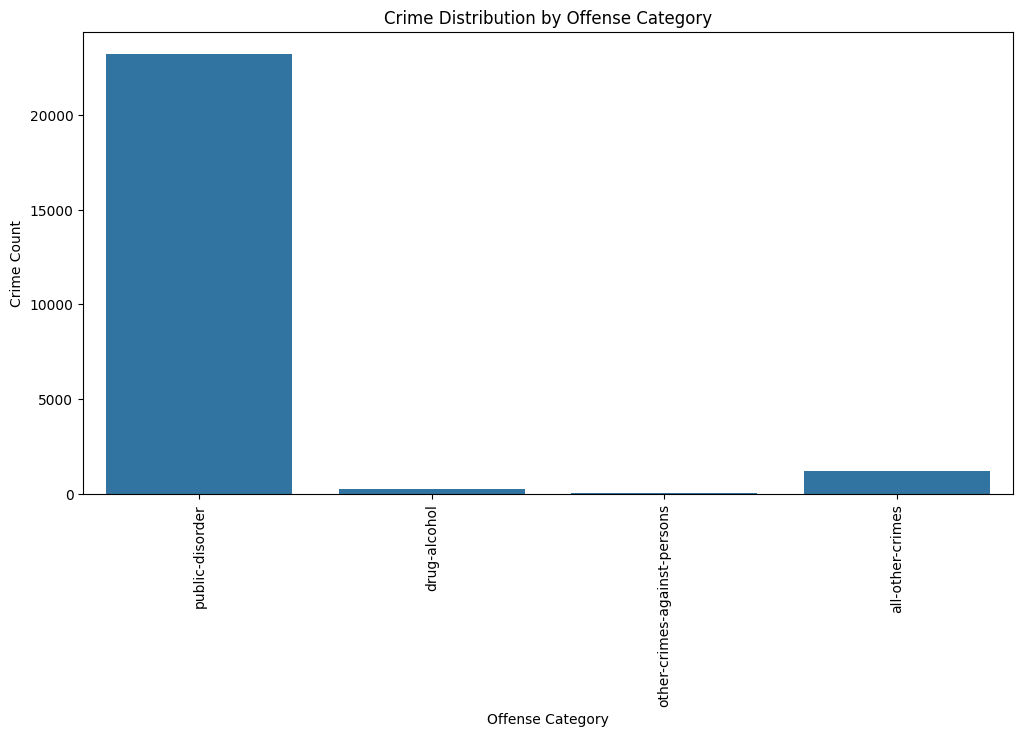

In [161]:
# 2. توزيع الجرائم حسب نوع الجريمة:
df_pandas = data_cleaned.groupBy("offense_category_id").count().toPandas()

# رسم البيانات
plt.figure(figsize=(12, 6))
sns.barplot(x="offense_category_id", y="count", data=df_pandas)
plt.title("Crime Distribution by Offense Category")
plt.xlabel("Offense Category")
plt.ylabel("Crime Count")
plt.xticks(rotation=90)
plt.show()

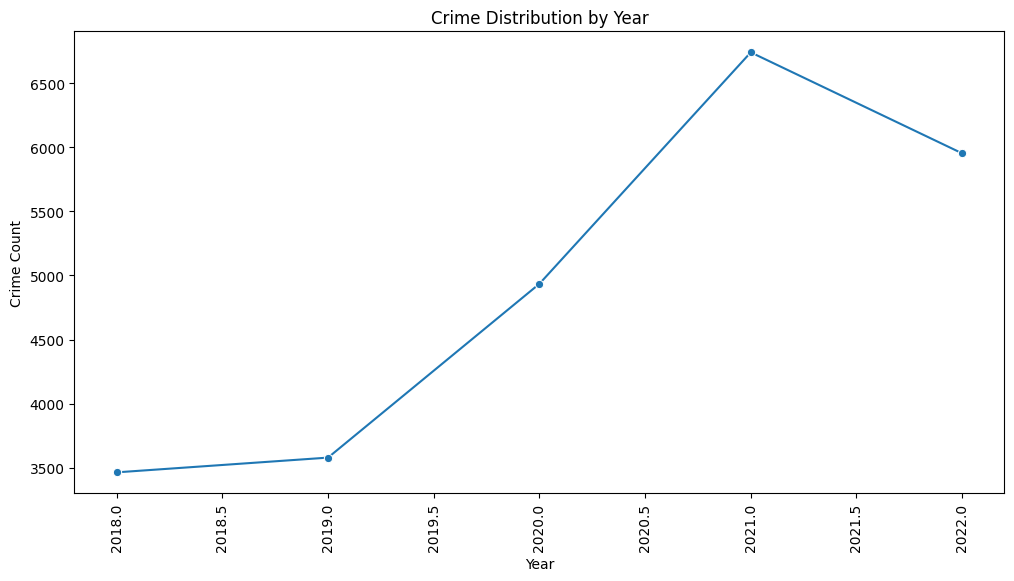

In [162]:
# 3. توزيع الجرائم حسب السنة:
df_pandas = data_cleaned.groupBy("Year").count().toPandas()

# رسم البيانات
plt.figure(figsize=(12, 6))
sns.lineplot(x="Year", y="count", data=df_pandas, marker='o')
plt.title("Crime Distribution by Year")
plt.xlabel("Year")
plt.ylabel("Crime Count")
plt.xticks(rotation=90)
plt.show()


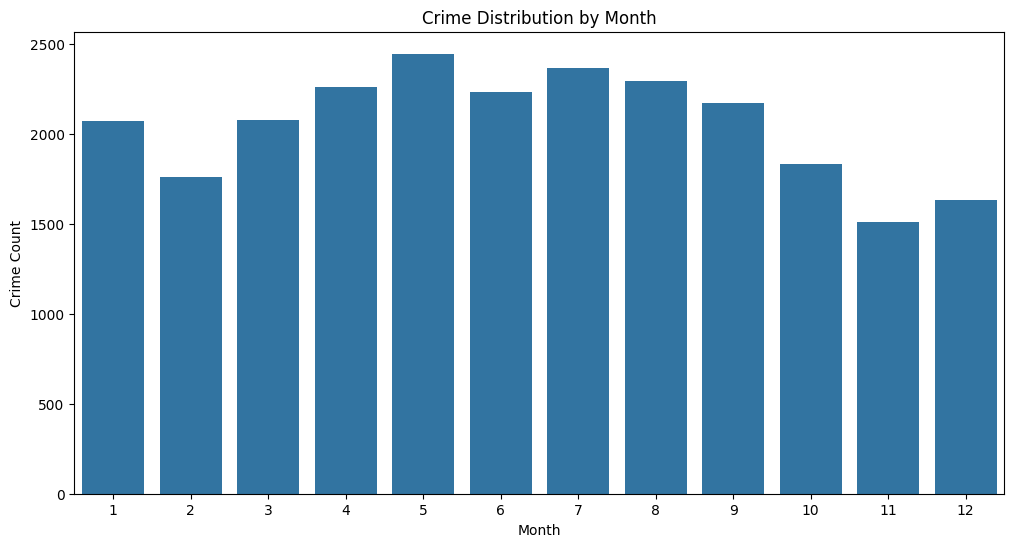

In [163]:
# 4. توزيع الجرائم حسب الشهر:
df_pandas = data_cleaned.groupBy("Month").count().toPandas()

# رسم البيانات
plt.figure(figsize=(12, 6))
sns.barplot(x="Month", y="count", data=df_pandas)
plt.title("Crime Distribution by Month")
plt.xlabel("Month")
plt.ylabel("Crime Count")
plt.show()


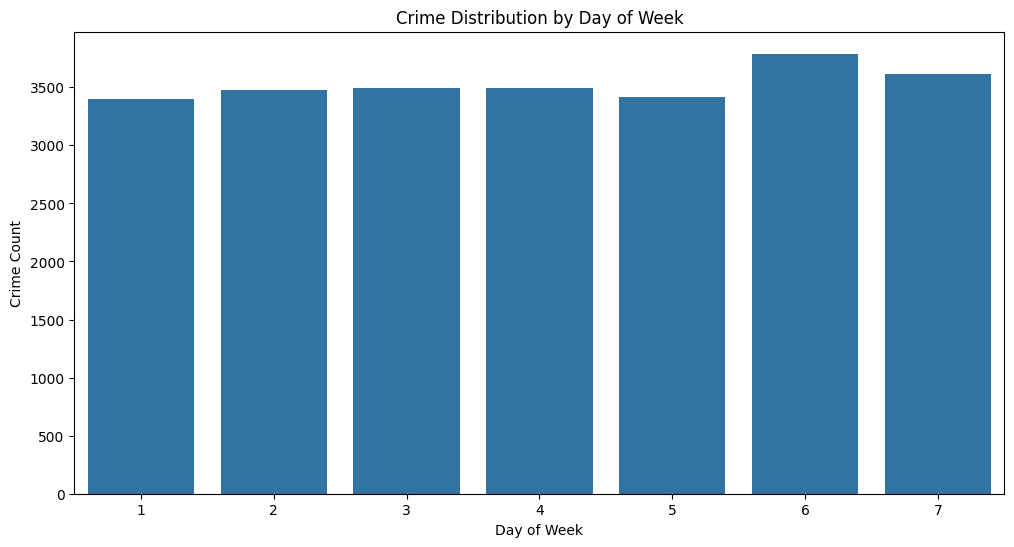

In [164]:
# 5. توزيع الجرائم حسب يوم الأسبوع:
df_pandas = data_cleaned.groupBy("DayOfWeek").count().toPandas()

# رسم البيانات
plt.figure(figsize=(12, 6))
sns.barplot(x="DayOfWeek", y="count", data=df_pandas)
plt.title("Crime Distribution by Day of Week")
plt.xlabel("Day of Week")
plt.ylabel("Crime Count")
plt.show()

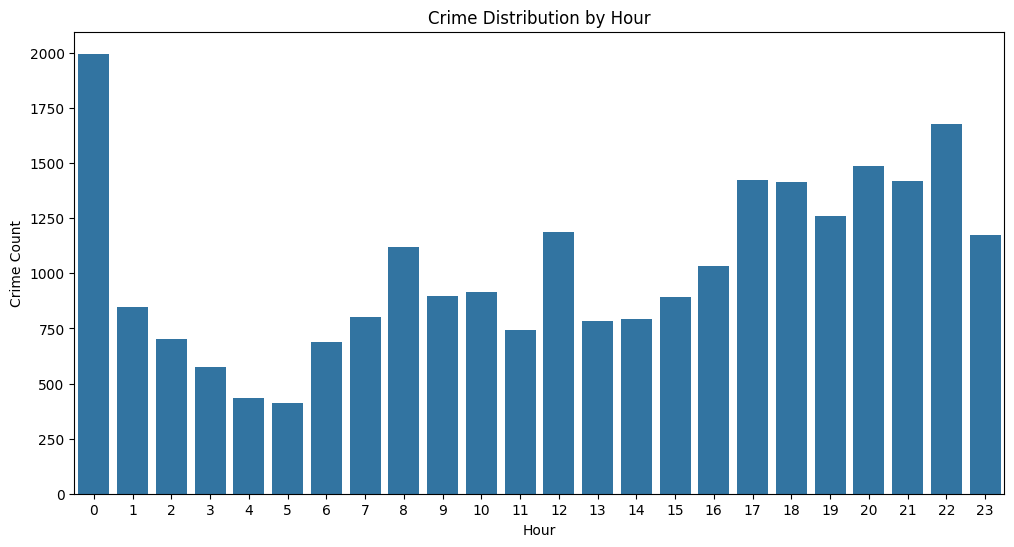

In [165]:
# 6. توزيع الجرائم حسب الساعة:
df_pandas = data_cleaned.groupBy("Hour").count().toPandas()

# رسم البيانات
plt.figure(figsize=(12, 6))
sns.barplot(x="Hour", y="count", data=df_pandas)
plt.title("Crime Distribution by Hour")
plt.xlabel("Hour")
plt.ylabel("Crime Count")
plt.show()

In [166]:
data_cleaned.groupBy("district_id").count().show()


+-----------+-----+
|district_id|count|
+-----------+-----+
|          7|  210|
|          3| 6819|
|          5| 2637|
|          U|    9|
|          6| 4601|
|          1| 3753|
|          4| 2832|
|          2| 3811|
+-----------+-----+



In [167]:
# الجزء ج: تحويل القيم النصية إلى عددية باستخدام StringIndexer:
from pyspark.ml.feature import StringIndexer

# تحويل القيم النصية في عمود "district_id" إلى قيم عددية
indexer_district = StringIndexer(inputCol="district_id", outputCol="district_id_indexed")
data_indexed = indexer_district.fit(data_cleaned).transform(data_cleaned)

# تحويل القيم النصية في عمود "offense_category_id" إلى قيم عددية
indexer_offense = StringIndexer(inputCol="offense_category_id", outputCol="offense_category_id_indexed")
data_indexed = indexer_offense.fit(data_indexed).transform(data_indexed)

# عرض البيانات بعد التحويل
data_indexed.show(5)


+-----------+-----------------+------------+----------------------+--------------------+-------------------+---------------------+--------------------+--------------------+------------------+---------+---------+------------+----------+-----------+-----------+---------------+--------+----------+------------+----+-----+---------+----+-------------------+---------------------------+
|incident_id|       offense_id|offense_code|offense_code_extension|     offense_type_id|offense_category_id|first_occurrence_date|last_occurrence_date|       reported_date|  incident_address|    geo_x|    geo_y|     geo_lon|   geo_lat|district_id|precinct_id|neighborhood_id|is_crime|is_traffic|victim_count|Year|Month|DayOfWeek|Hour|district_id_indexed|offense_category_id_indexed|
+-----------+-----------------+------------+----------------------+--------------------+-------------------+---------------------+--------------------+--------------------+------------------+---------+---------+------------+----------

In [168]:
# الجزء د: إعداد البيانات لمهام التعلم الآلي:

from pyspark.ml.feature import VectorAssembler

# تحديد الأعمدة التي سيتم استخدامها كميزات
feature_columns = ["offense_code", "offense_code_extension", "district_id_indexed", "Year", "Month", "DayOfWeek", "Hour", "geo_lon", "geo_lat"]
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")

# تحويل البيانات إلى تنسيق يتناسب مع نماذج التعلم الآلي
final_data = assembler.transform(data_indexed).select("features", "offense_category_id_indexed")


In [169]:
# تقسيم مجموعة البيانات إلى تدريب واختبار:

train_data, test_data = final_data.randomSplit([0.8, 0.2], seed=1234)


In [170]:
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# إنشاء نموذج الغابات العشوائية
rf = RandomForestClassifier(labelCol="offense_category_id_indexed", featuresCol="features")
rf_model = rf.fit(train_data)

# التنبؤ باستخدام النموذج
predictions = rf_model.transform(test_data)
predictions.select("prediction", "offense_category_id_indexed", "features").show(5)

# تقييم النموذج
evaluator = MulticlassClassificationEvaluator(labelCol="offense_category_id_indexed", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print(f"Accuracy: {accuracy}")


+----------+---------------------------+--------------------+
|prediction|offense_category_id_indexed|            features|
+----------+---------------------------+--------------------+
|       0.0|                        0.0|[2999.0,0.0,0.0,2...|
|       0.0|                        0.0|[2999.0,0.0,0.0,2...|
|       0.0|                        0.0|[2999.0,0.0,0.0,2...|
|       0.0|                        0.0|[2999.0,0.0,0.0,2...|
|       0.0|                        0.0|[2999.0,0.0,0.0,2...|
+----------+---------------------------+--------------------+
only showing top 5 rows

Accuracy: 0.997758761206194


In [171]:
from pyspark.ml.classification import MultilayerPerceptronClassifier

# تحديد طبقات الشبكة العصبية
layers = [len(feature_columns), 64, 32, len(data_indexed.select("offense_category_id_indexed").distinct().collect())]

# إنشاء النموذج
mlp = MultilayerPerceptronClassifier(labelCol="offense_category_id_indexed", featuresCol="features", layers=layers, blockSize=128, seed=1234, maxIter=100)
mlp_model = mlp.fit(train_data)

# التنبؤ باستخدام النموذج
predictions_mlp = mlp_model.transform(test_data)
predictions_mlp.select("prediction", "offense_category_id_indexed", "features").show(5)

# تقييم النموذج
accuracy_mlp = evaluator.evaluate(predictions_mlp)
print(f"MLP Accuracy: {accuracy_mlp}")

+----------+---------------------------+--------------------+
|prediction|offense_category_id_indexed|            features|
+----------+---------------------------+--------------------+
|       0.0|                        0.0|[2999.0,0.0,0.0,2...|
|       0.0|                        0.0|[2999.0,0.0,0.0,2...|
|       0.0|                        0.0|[2999.0,0.0,0.0,2...|
|       0.0|                        0.0|[2999.0,0.0,0.0,2...|
|       0.0|                        0.0|[2999.0,0.0,0.0,2...|
+----------+---------------------------+--------------------+
only showing top 5 rows

MLP Accuracy: 0.9983700081499592
